In [65]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from tqdm import tqdm

In [66]:
def generate_economic_scenarios(n_scenarios=100, n_periods=60):
    """Generate synthetic economic scenarios (GDP growth-like)"""
    base_trend = np.linspace(0, 0.5, n_periods)
    scenarios = np.zeros((n_periods, n_scenarios))
    
    for i in range(n_scenarios):
        # Random walk with drift and shocks
        drift = np.random.normal(0.01, 0.005)
        volatility = np.random.uniform(0.05, 0.2)
        shocks = np.random.normal(0, volatility, n_periods)
        
        # Combine components
        scenarios[:, i] = base_trend + np.cumsum(drift + shocks)
        
        # Add business cycles
        cycle = 0.1 * np.sin(np.linspace(0, 4*np.pi, n_periods) + np.random.uniform(0, 2*np.pi))
        scenarios[:, i] += cycle
        
    return scenarios

def kantorovich_matrix(scenarios):
    """Compute pairwise Wasserstein distances between scenarios"""
    n = scenarios.shape[1]
    dist_matrix = np.zeros((n, n))
    
    for i in tqdm(range(n), desc="Computing Kantorovich distances"):
        for j in range(i+1, n):
            dist_matrix[i,j] = wasserstein_distance(scenarios[:,i], scenarios[:,j])
            dist_matrix[j,i] = dist_matrix[i,j]
    
    return dist_matrix

Computing Kantorovich distances: 100%|██████████| 10/10 [00:00<00:00, 3337.55it/s]


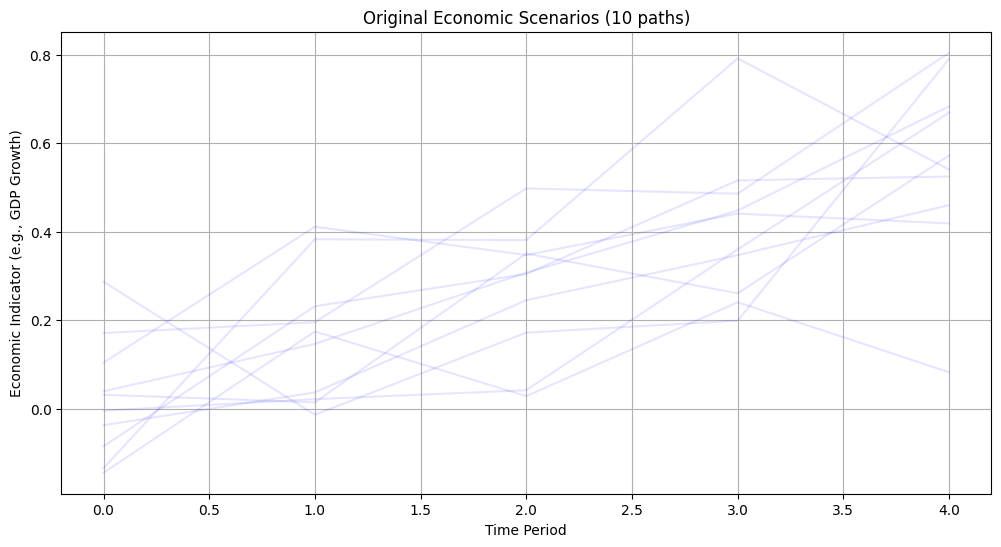

In [67]:
n_scenarios = 10
K = 5
n_periods = 5  # 10 years of monthly data
economic_ts = generate_economic_scenarios(n_scenarios, n_periods)
dist_matrix = kantorovich_matrix(economic_ts)

# Plot all scenarios
plt.figure(figsize=(12, 6))
plt.plot(economic_ts, alpha=0.1, color='blue')
plt.title(f"Original Economic Scenarios ({n_scenarios} paths)")
plt.xlabel("Time Period")
plt.ylabel("Economic Indicator (e.g., GDP Growth)")
plt.grid(True)
plt.show()

Scenario Reduction using Classical Clustering

In [68]:
def cluster_scenario_reduction(scenarios, n_clusters=15):
    """Optimal scenario reduction using K-means clustering"""
    # Compute distance matrix
    dist_matrix = kantorovich_matrix(scenarios)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, 
                    random_state=42, 
                    n_init=10)
    clusters = kmeans.fit_predict(dist_matrix)
    
    # Select representative scenarios (closest to centroids)
    representatives = []
    for c in range(n_clusters):
        cluster_members = np.where(clusters == c)[0]
        centroid_distances = dist_matrix[cluster_members][:, cluster_members].mean(axis=1)
        representatives.append(cluster_members[np.argmin(centroid_distances)])
    
    return np.array(representatives), clusters

Computing Kantorovich distances: 100%|██████████| 10/10 [00:00<00:00, 8320.38it/s]


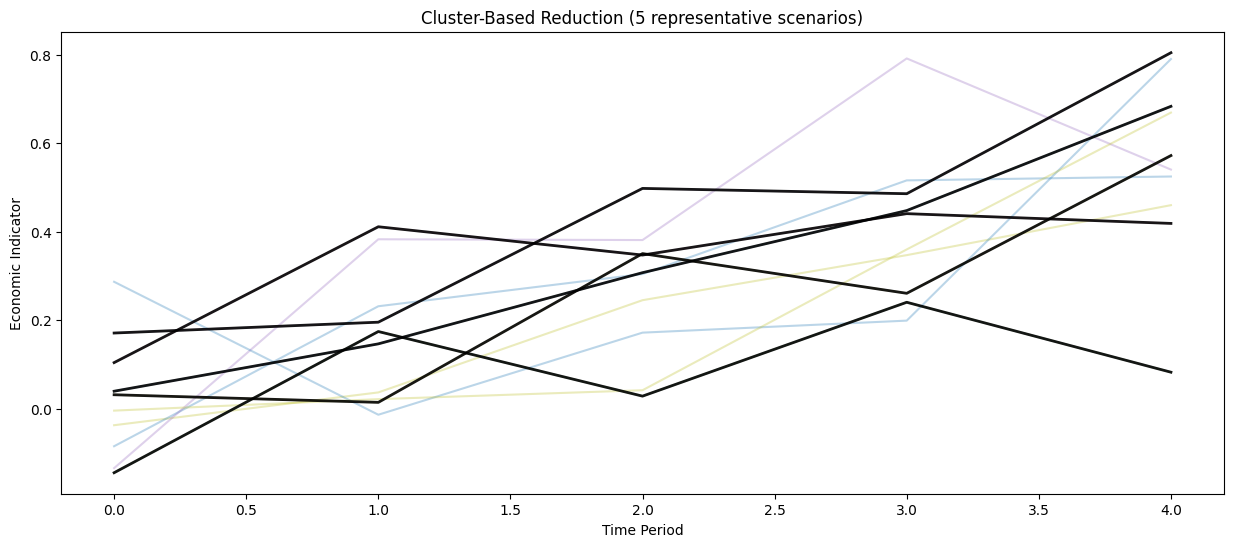

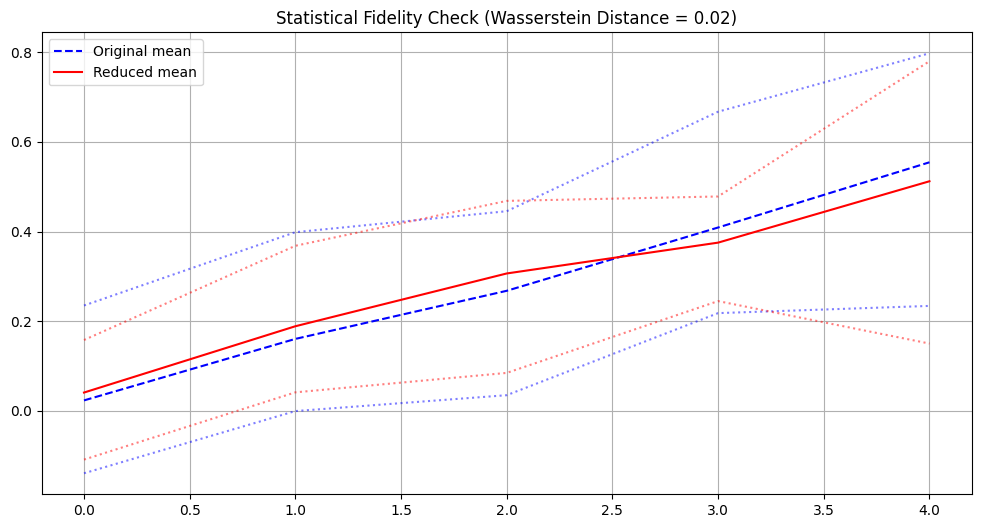

In [69]:
# Cluster reduction
rep_idx, cluster_assignments = cluster_scenario_reduction(economic_ts, K)

# Plot results
plt.figure(figsize=(15,6))

# Plot clustered scenarios
colors = plt.cm.tab20(cluster_assignments / K)
for i in range(economic_ts.shape[1]):
    plt.plot(economic_ts[:,i], color=colors[i], alpha=0.3)

# Plot representatives
plt.plot(economic_ts[:,rep_idx], 'k-', linewidth=2, alpha=0.9)
plt.title(f"Cluster-Based Reduction ({K} representative scenarios)")
plt.xlabel("Time Period")
plt.ylabel("Economic Indicator")

# Plot statistical fidelity
plt.figure(figsize=(12,6))
plt.plot(np.mean(economic_ts, axis=1), 'b--', label='Original mean')
plt.plot(np.mean(economic_ts[:,rep_idx], axis=1), 'r-', label='Reduced mean')
plt.plot(np.quantile(economic_ts, 0.05, axis=1), 'b:', alpha=0.5)
plt.plot(np.quantile(economic_ts, 0.95, axis=1), 'b:', alpha=0.5)
plt.plot(np.quantile(economic_ts[:,rep_idx], 0.05, axis=1), 'r:', alpha=0.5)
plt.plot(np.quantile(economic_ts[:,rep_idx], 0.95, axis=1), 'r:', alpha=0.5)
plt.title("Statistical Fidelity Check (Wasserstein Distance = {:.2f})".format(
    wasserstein_distance(economic_ts.flatten(), economic_ts[:,rep_idx].flatten())))
plt.legend()
plt.grid(True)
plt.show()

Scenario Reduction - Backward Reduction method

In [70]:
def backward_reduction_ts(scenarios, n_keep, dist_matrix, probs=None):
    n_scenarios = scenarios.shape[1]
    probs = np.full(n_scenarios, 1/n_scenarios) if probs is None else probs
    kept = set(range(n_scenarios))
    
    with tqdm(total=n_scenarios-n_keep, desc="Backward reduction") as pbar:
        while len(kept) > n_keep:
            removal_costs = []
            for candidate in kept:
                temp_kept = kept - {candidate}
                cost = probs[candidate] * np.min(dist_matrix[candidate, list(temp_kept)])
                removal_costs.append((cost, candidate))
            
            _, to_remove = min(removal_costs)
            kept.remove(to_remove)
            pbar.update(1)
    
    return np.array(sorted(kept))

def forward_selection_ts(scenarios, n_keep, dist_matrix, probs=None):
    n_scenarios = scenarios.shape[1]
    probs = np.full(n_scenarios, 1/n_scenarios) if probs is None else probs
    kept = set()
    remaining = set(range(n_scenarios))
    
    with tqdm(total=n_keep, desc="Forward selection") as pbar:
        while len(kept) < n_keep:
            addition_costs = []
            current_min_dists = np.array([np.min(dist_matrix[i, list(kept)]) if kept else np.inf for i in remaining])
            
            for candidate in remaining:
                new_min_dists = np.minimum(current_min_dists, dist_matrix[list(remaining), candidate])
                cost = np.sum(probs[list(remaining)] * new_min_dists)
                addition_costs.append((cost, candidate))
            
            _, to_add = min(addition_costs)
            kept.add(to_add)
            remaining.remove(to_add)
            pbar.update(1)
    
    return np.array(sorted(kept))

Forward selection: 100%|██████████| 5/5 [00:00<00:00, 2474.81it/s]


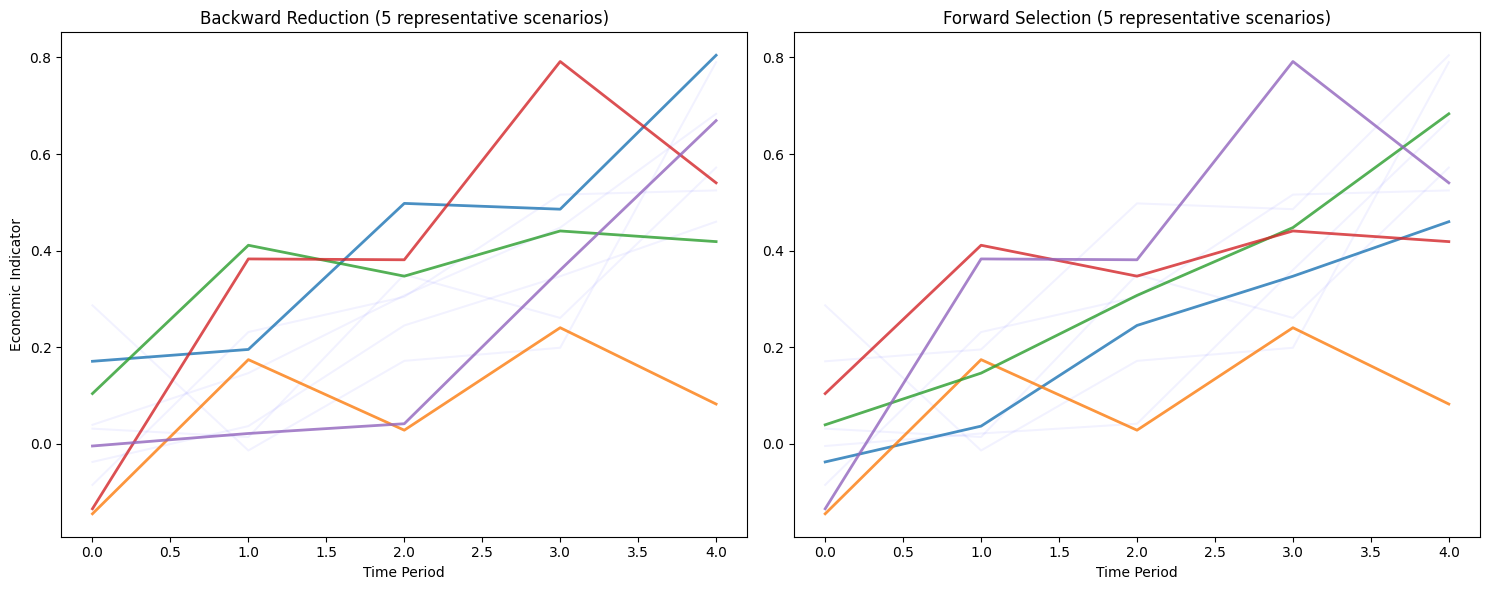

In [71]:
backward_idx = backward_reduction_ts(economic_ts, K, dist_matrix)

forward_idx = forward_selection_ts(economic_ts, K, dist_matrix)

# Plot results
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(economic_ts, alpha=0.05, color='blue')
plt.plot(economic_ts[:, backward_idx], alpha=0.8, linewidth=2)
plt.title(f"Backward Reduction ({K} representative scenarios)")
plt.xlabel("Time Period")
plt.ylabel("Economic Indicator")

plt.subplot(122)
plt.plot(economic_ts, alpha=0.05, color='blue')
plt.plot(economic_ts[:, forward_idx], alpha=0.8, linewidth=2)
plt.title(f"Forward Selection ({K} representative scenarios)")
plt.xlabel("Time Period")

plt.tight_layout()
plt.show()

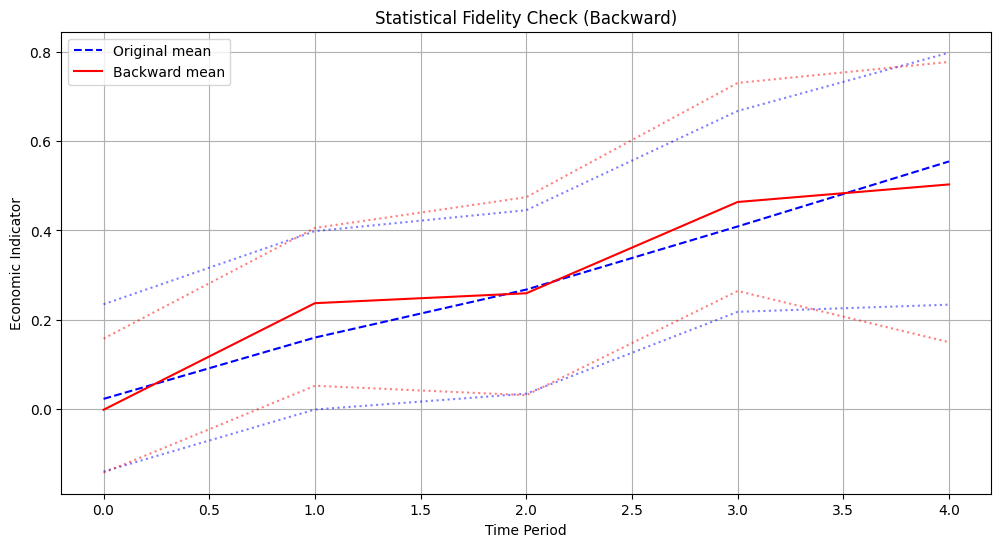

In [72]:
plt.figure(figsize=(12, 6))

plt.plot(np.mean(economic_ts, axis=1), 'b--', label='Original mean')
plt.plot(np.quantile(economic_ts, 0.05, axis=1), 'b:', alpha=0.5)
plt.plot(np.quantile(economic_ts, 0.95, axis=1), 'b:', alpha=0.5)

plt.plot(np.mean(economic_ts[:, backward_idx], axis=1), 'r-', label='Backward mean')
plt.plot(np.quantile(economic_ts[:, backward_idx], 0.05, axis=1), 'r:', alpha=0.5)
plt.plot(np.quantile(economic_ts[:, backward_idx], 0.95, axis=1), 'r:', alpha=0.5)

plt.title("Statistical Fidelity Check (Backward)")
plt.xlabel("Time Period")
plt.ylabel("Economic Indicator")
plt.legend()
plt.grid(True)
plt.show()

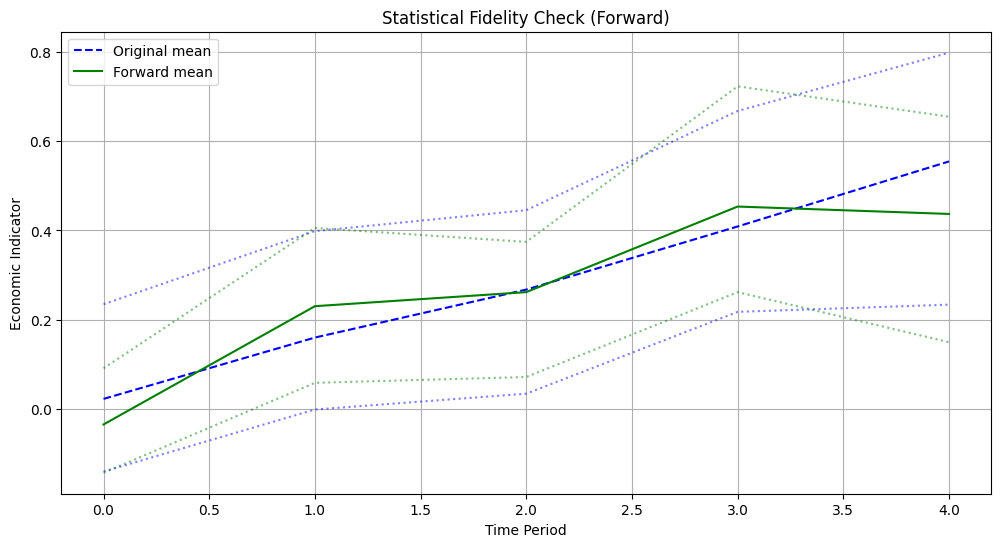

In [73]:
plt.figure(figsize=(12, 6))

# Original distribution (blue)
plt.plot(np.mean(economic_ts, axis=1), 'b--', label='Original mean')
plt.plot(np.quantile(economic_ts, 0.05, axis=1), 'b:', alpha=0.5)
plt.plot(np.quantile(economic_ts, 0.95, axis=1), 'b:', alpha=0.5)

# Reduced distribution (green)
plt.plot(np.mean(economic_ts[:, forward_idx], axis=1), 'g-', label='Forward mean')
plt.plot(np.quantile(economic_ts[:, forward_idx], 0.05, axis=1), 'g:', alpha=0.5)
plt.plot(np.quantile(economic_ts[:, forward_idx], 0.95, axis=1), 'g:', alpha=0.5)

plt.title("Statistical Fidelity Check (Forward)")
plt.xlabel("Time Period")
plt.ylabel("Economic Indicator")
plt.legend()
plt.grid(True)
plt.show()

Quantum Optimization with Qiskit - QUBO

In [74]:
from qiskit_optimization import QuadraticProgram

n = n_scenarios

qp = QuadraticProgram()

for i in range(n):
    qp.binary_var(name=f'x_{i}')

linear_coeffs = {f'x_{i}': 1 for i in range(n)}
qp.linear_constraint(linear=linear_coeffs, sense='==', rhs=K, name='cardinality')

obj = {}
for i in range(n):
    for j in range(i+1, n):
        obj[(f'x_{i}', f'x_{j}')] = dist_matrix[i, j]

qp.minimize(quadratic=obj)

In [75]:
print(qp.prettyprint())

Problem name: 

Minimize
  0.2205475760783793*x_0*x_1 + 0.13407917600028904*x_0*x_2
  + 0.10699280300085898*x_0*x_3 + 0.03759825596694437*x_0*x_4
  + 0.11453078252552254*x_0*x_5 + 0.14171725392217985*x_0*x_6
  + 0.22073097830808056*x_0*x_7 + 0.11905677826843596*x_0*x_8
  + 0.0947385396932814*x_0*x_9 + 0.3546267520786683*x_1*x_2
  + 0.15420533696883484*x_1*x_3 + 0.185053680135712*x_1*x_4
  + 0.10601679355285673*x_1*x_5 + 0.14716934124567438*x_1*x_6
  + 0.1298371710097289*x_1*x_7 + 0.14404889822608938*x_1*x_8
  + 0.21326782439884598*x_1*x_9 + 0.22208458364006584*x_2*x_3
  + 0.16957307194295634*x_2*x_4 + 0.24860995852581158*x_2*x_5
  + 0.26812988879361027*x_2*x_6 + 0.3160442657644602*x_2*x_7
  + 0.21057785385257893*x_2*x_8 + 0.16038110919914939*x_2*x_9
  + 0.11106872755801672*x_3*x_4 + 0.08780953258393391*x_3*x_5
  + 0.11851269869124299*x_3*x_6 + 0.11373817530722158*x_3*x_7
  + 0.14612345292965442*x_3*x_8 + 0.17066661653274096*x_3*x_9
  + 0.07903688658285525*x_4*x_5 + 0.15104604803330285*

QUBO transformation

In [76]:
# We want to convert the linear equality constraint into an additional quadratic penalty
# term of the objective function to map the Quadratic Program to an unconstrained form.

# The resulting problem is now a QUBO and is compatible with many quantum optimization
# algorithms such as VQE, QAOA...

from qiskit_optimization.converters import LinearEqualityToPenalty

lineq2penalty = LinearEqualityToPenalty()
qubo = lineq2penalty.convert(qp)
print(qubo.prettyprint())

Problem name: 

Minimize
  8.092391016750266*x_0^2 + 16.405329609578914*x_0*x_1
  + 16.318861209500824*x_0*x_2 + 16.29177483650139*x_0*x_3
  + 16.222380289467477*x_0*x_4 + 16.299312816026053*x_0*x_5
  + 16.326499287422713*x_0*x_6 + 16.405513011808615*x_0*x_7
  + 16.30383881176897*x_0*x_8 + 16.279520573193814*x_0*x_9
  + 8.092391016750266*x_1^2 + 16.539408785579198*x_1*x_2
  + 16.33898737046937*x_1*x_3 + 16.369835713636242*x_1*x_4
  + 16.29079882705339*x_1*x_5 + 16.331951374746208*x_1*x_6
  + 16.31461920451026*x_1*x_7 + 16.32883093172662*x_1*x_8
  + 16.39804985789938*x_1*x_9 + 8.092391016750266*x_2^2
  + 16.4068666171406*x_2*x_3 + 16.35435510544349*x_2*x_4
  + 16.433391992026344*x_2*x_5 + 16.452911922294142*x_2*x_6
  + 16.500826299264993*x_2*x_7 + 16.39535988735311*x_2*x_8
  + 16.345163142699683*x_2*x_9 + 8.092391016750266*x_3^2
  + 16.29585076105855*x_3*x_4 + 16.272591566084465*x_3*x_5
  + 16.303294732191773*x_3*x_6 + 16.29852020880775*x_3*x_7
  + 16.330905486430186*x_3*x_8 + 16.355448

In [77]:
import copy
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem

qp = relax_problem(QuadraticProgramToQubo().convert(qubo))
print(qp.prettyprint())

algorithm_globals.random_seed = 12345
qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 1.0])
exact_mes = NumPyMinimumEigensolver()

qaoa = MinimumEigenOptimizer(qaoa_mes)

qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

Problem name: 

Minimize
  8.092391016750266*x_0^2 + 16.405329609578914*x_0*x_1
  + 16.318861209500824*x_0*x_2 + 16.29177483650139*x_0*x_3
  + 16.222380289467477*x_0*x_4 + 16.299312816026053*x_0*x_5
  + 16.326499287422713*x_0*x_6 + 16.405513011808615*x_0*x_7
  + 16.30383881176897*x_0*x_8 + 16.279520573193814*x_0*x_9
  + 8.092391016750266*x_1^2 + 16.539408785579198*x_1*x_2
  + 16.33898737046937*x_1*x_3 + 16.369835713636242*x_1*x_4
  + 16.29079882705339*x_1*x_5 + 16.331951374746208*x_1*x_6
  + 16.31461920451026*x_1*x_7 + 16.32883093172662*x_1*x_8
  + 16.39804985789938*x_1*x_9 + 8.092391016750266*x_2^2
  + 16.4068666171406*x_2*x_3 + 16.35435510544349*x_2*x_4
  + 16.433391992026344*x_2*x_5 + 16.452911922294142*x_2*x_6
  + 16.500826299264993*x_2*x_7 + 16.39535988735311*x_2*x_8
  + 16.345163142699683*x_2*x_9 + 8.092391016750266*x_3^2
  + 16.29585076105855*x_3*x_4 + 16.272591566084465*x_3*x_5
  + 16.303294732191773*x_3*x_6 + 16.29852020880775*x_3*x_7
  + 16.330905486430186*x_3*x_8 + 16.355448

C:\Users\antho\AppData\Local\Temp\ipykernel_49232\1941962825.py:26: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 1.0])


objective function value: 0.9184905124677982
variable values: x_0=1.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS


Translate QUBO to Ising Operator

In [78]:
op, offset = qubo.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(op)

offset: 22.004075296063245
operator:
SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII', 'IIIIIIIIZZ', 'IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IIIIZIIIIZ', 'IIIZIIIIIZ', 'IIZIIIIIIZ', 'IZIIIIIIIZ', 'ZIIIIIIIIZ', 'IIIIIIIZZI', 'IIIIIIZIZI', 'IIIIIZIIZI', 'IIIIZIIIZI', 'IIIZIIIIZI', 'IIZIIIIIZI', 'IZIIIIIIZI', 'ZIIIIIIIZI', 'IIIIIIZZII', 'IIIIIZIZII', 'IIIIZIIZII', 'IIIZIIIZII', 'IIZIIIIZII', 'IZIIIIIZII', 'ZIIIIIIZII', 'IIIIIZZIII', 'IIIIZIZIII', 'IIIZIIZIII', 'IIZIIIZIII', 'IZIIIIZIII', 'ZIIIIIZIII', 'IIIIZZIIII', 'IIIZIZIIII', 'IIZIIZIIII', 'IZIIIZIIII', 'ZIIIIZIIII', 'IIIZZIIIII', 'IIZIZIIIII', 'IZIIZIIIII', 'ZIIIZIIIII', 'IIZZIIIIII', 'IZIZIIIIII', 'ZIIZIIIIII', 'IZZIIIIIII', 'ZIZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[-0.29749804+0.j, -0.41369334+0.j, -0.52102666+0.j, -0.30780048+0.j,
 -0.27811175+0.j, -0.27480064+0.j, -0.38116152+0.j, -0.41452582+0.j,
 -0.31656115+0.j, 

Map Hamiltonian to Quantum Circuit

In [79]:
from qiskit.circuit.library import QAOAAnsatz

ansatz = QAOAAnsatz(op, reps=1)

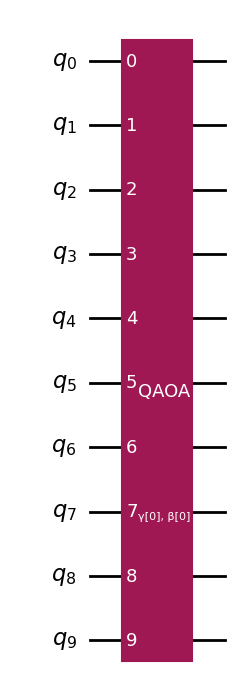

In [80]:
ansatz.draw('mpl')

Optimize for quantum execution

# Solve the QUBO

Solve the QUBO with the MinimumEigenOptimizer

In [81]:
from qiskit.primitives import Sampler
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

algorithm_globals.random_seed = 10598

qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 0.0])
exact_mes = NumPyMinimumEigensolver()

C:\Users\antho\AppData\Local\Temp\ipykernel_49232\3707406802.py:9: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=[0.0, 0.0])


In [82]:
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(exact_mes)

Optimal benchmark solution: use the MinimumEigenOptimize bazed on the classical exact NumpyMinimumEigenSolver to get the optimal benchmark solution for this example.

In [83]:
exact_result = exact.solve(qubo)
print(exact_result.prettyprint())

objective function value: 0.9184905124677982
variable values: x_0=1.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS


Now, we apply the MinimumEigenOptimizer based on QAOA to the same problem

In [84]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

objective function value: 0.9184905124677982
variable values: x_0=1.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0
status: SUCCESS


OptimizationResult provides useful information in the form of SolutionSamples (here denoted as samples). Each SolutionSample contains information about the input values (x), the corresponding objective function value (fval), the fraction of samples corresponding to that input (probability), and the solution status (SUCCESS, FAILURE, INFEASIBLE). Multiple samples corresponding to the same input are consolidated into a single SolutionSample (with its probability attribute being the aggregate fraction of samples represented by that SolutionSample).

In [85]:
print("variable order:", [var.name for var in qaoa_result.variables])
for s in qaoa_result.samples:
    print(s)

variable order: ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']
SolutionSample(x=array([1., 0., 0., 0., 1., 1., 0., 0., 1., 1.]), fval=0.9184905124677982, probability=0.0009765625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0., 1., 1., 1., 0., 0., 0., 1.]), fval=0.9805197537870072, probability=0.0009765625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0., 1., 1., 1., 0., 0., 1., 0.]), fval=0.9954841879348919, probability=0.0009765625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0., 1., 1., 0., 0., 0., 1., 1.]), fval=1.0616102280244206, probability=0.0009765625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0., 1., 1., 1., 0., 0., 1., 1.]), fval=1.0682344856179782, probability=0.0009765625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0., 1., 1., 1., 1., 0., 0., 0.]), fval=1.0764216281006895, probabi

Now, run it on a real quantum machine

In [86]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

service = QiskitRuntimeService()

In [87]:
for backend in service.backends():
    try:
      qubit_count = len(backend.properties().qubits)
    except:
      qubit_count = 'Simulated'
    
    print(f"{backend.name} has {backend.status().pending_jobs} queued and {qubit_count} qubits")

ibm_brisbane has 11 queued and 127 qubits
ibm_kyiv has 7 queued and 127 qubits
ibm_sherbrooke has 2 queued and 127 qubits


In [88]:
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=1)
print(backend.name)

ibm_sherbrooke


In [100]:
op, offset = qubo.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(op)

ansatz = QAOAAnsatz(op, reps=1)

offset: 22.004075296063245
operator:
SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII', 'IIIIIIIIZZ', 'IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IIIIZIIIIZ', 'IIIZIIIIIZ', 'IIZIIIIIIZ', 'IZIIIIIIIZ', 'ZIIIIIIIIZ', 'IIIIIIIZZI', 'IIIIIIZIZI', 'IIIIIZIIZI', 'IIIIZIIIZI', 'IIIZIIIIZI', 'IIZIIIIIZI', 'IZIIIIIIZI', 'ZIIIIIIIZI', 'IIIIIIZZII', 'IIIIIZIZII', 'IIIIZIIZII', 'IIIZIIIZII', 'IIZIIIIZII', 'IZIIIIIZII', 'ZIIIIIIZII', 'IIIIIZZIII', 'IIIIZIZIII', 'IIIZIIZIII', 'IIZIIIZIII', 'IZIIIIZIII', 'ZIIIIIZIII', 'IIIIZZIIII', 'IIIZIZIIII', 'IIZIIZIIII', 'IZIIIZIIII', 'ZIIIIZIIII', 'IIIZZIIIII', 'IIZIZIIIII', 'IZIIZIIIII', 'ZIIIZIIIII', 'IIZZIIIIII', 'IZIZIIIIII', 'ZIIZIIIIII', 'IZZIIIIIII', 'ZIZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[-0.29749804+0.j, -0.41369334+0.j, -0.52102666+0.j, -0.30780048+0.j,
 -0.27811175+0.j, -0.27480064+0.j, -0.38116152+0.j, -0.41452582+0.j,
 -0.31656115+0.j, 

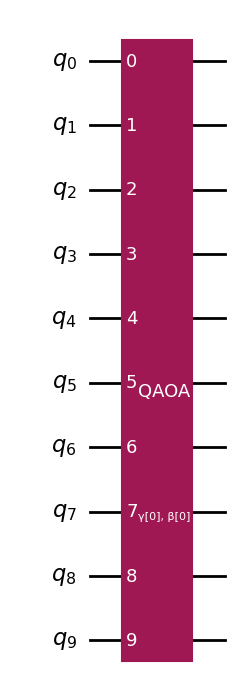

In [101]:
ansatz.draw(output="mpl")

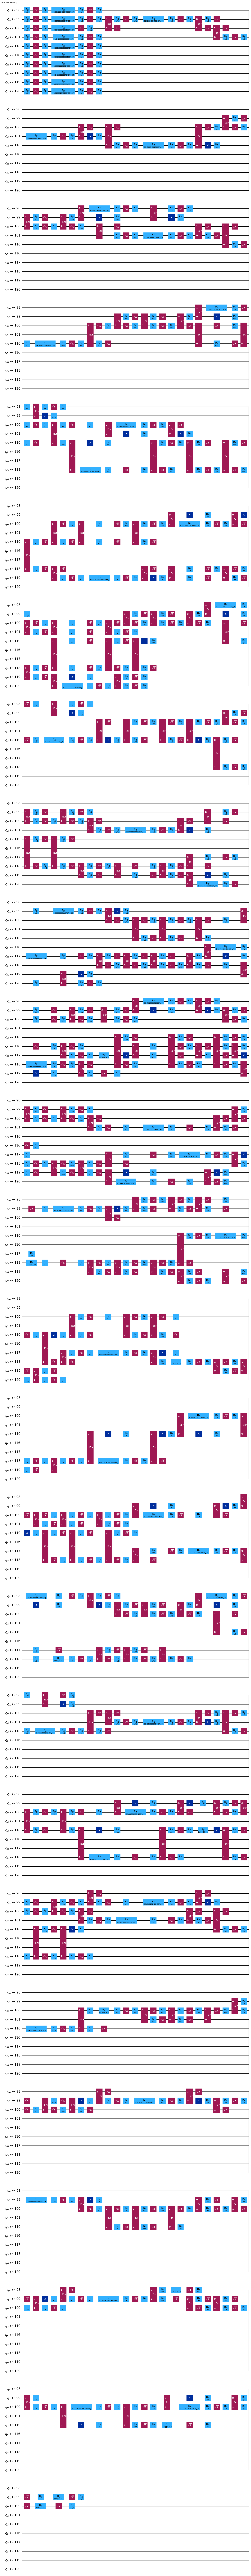

In [95]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=1)

ansatz_isa = pm.run(ansatz)
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [92]:
hamiltonian_isa = op.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

It appears V2 primitives do not support that yet; let's stick to local testing mode with Qiskit Aer backend and the V1 primitives